<a href="https://colab.research.google.com/github/nvinogradskaya/Geolife/blob/main/DeepMove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm.auto import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate, LayerNormalization, Attention
from tensorflow.keras.callbacks import EarlyStopping
from geopy.distance import geodesic
import matplotlib.pyplot as plt

In [ ]:
MAX_USERS = 170
SEQ_LENGTH = 10
LSTM_UNITS = 128
BATCH_SIZE = 128
EPOCHS = 20
TEST_SIZE = 0.3
EMBEDDING_DIM = 32

In [ ]:
def load_data_with_stay_points(data_path):
    data = []
    user_map = {}
    user_dirs = sorted(os.listdir(data_path))[:MAX_USERS]

    for idx, user in enumerate(tqdm(user_dirs, desc="Users")):
        user_map[user] = idx
        traj_dir = os.path.join(data_path, user, 'Trajectory')

        plt_files = [f for f in os.listdir(traj_dir) if f.endswith('.plt')]
        for file in plt_files:
            df = pd.read_csv(
                os.path.join(traj_dir, file),
                skiprows=6,
                header=None,
                usecols=[0, 1, 3, 5, 6],
                names=['lat', 'lon', 'alt', 'date', 'time']
            )
            df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], errors='coerce')
            df.dropna(subset=['datetime'], inplace=True)
            df['user_id'] = idx

            stay_df = detect_stay_points(df, dist_thresh=50, time_thresh=600)
            if stay_df is not None and len(stay_df) > SEQ_LENGTH:
                data.append(stay_df)

    if not data:
        raise ValueError("No valid data after processing")

    df_all = pd.concat(data, ignore_index=True)

    df_all = df_all[
        (df_all.lat.between(-90, 90)) &
        (df_all.lon.between(-180, 180)) &
        ~((df_all.lat == 0) & (df_all.lon == 0))
    ].dropna()

    scaler = MinMaxScaler()
    df_all[['lat', 'lon', 'alt']] = scaler.fit_transform(df_all[['lat', 'lon', 'alt']])

    print(f"\nLoaded {len(df_all)} points from {len(user_map)} users")
    print(f"Average points per user: {len(df_all)/len(user_map):.1f}")

    return df_all, user_map, scaler

In [ ]:
def detect_stay_points(df, dist_thresh=50, time_thresh=600):
    stays = []
    i = 0
    while i < len(df)-1:
        j = i+1
        valid_points = 0

        while j < len(df):
            try:
                d = geodesic((df.iloc[i].lat, df.iloc[i].lon),
                            (df.iloc[j].lat, df.iloc[j].lon)).meters
                t = (df.iloc[j].datetime - df.iloc[i].datetime).total_seconds()

                if d > dist_thresh or t > time_thresh:
                    if valid_points >= 3:
                        stays.append({
                            'lat': df.iloc[i:j].lat.mean(),
                            'lon': df.iloc[i:j].lon.mean(),
                            'alt': df.iloc[i:j].alt.mean(),
                            'datetime': df.iloc[i].datetime,
                            'user_id': df.iloc[i].user_id
                        })
                    break
                valid_points += 1
                j += 1
            except:
                j += 1
        i = j if j > i else i+1

    return pd.DataFrame(stays) if stays else None

In [ ]:
def create_sequences(df, seq_length=SEQ_LENGTH, step=1, test_size=TEST_SIZE):
    X_train, X_test = [], []
    y_train, y_test = [], []
    u_train, u_test = [], []
    t_train, t_test = [], []

    df = df.sort_values(['user_id', 'datetime'])
    for uid in tqdm(df.user_id.unique(), desc="Creating sequences"):
        user_df = df[df.user_id == uid]
        if len(user_df) < seq_length + 1:
            continue

        split_idx = int(len(user_df) * (1 - test_size))
        train_user = user_df.iloc[:split_idx]
        test_user = user_df.iloc[split_idx:]

        for i in range(0, len(train_user) - seq_length, step):
            seq = train_user.iloc[i:i+seq_length]
            target = train_user.iloc[i+seq_length]
            X_train.append(seq[['lat', 'lon', 'alt']].values)
            y_train.append(target[['lat', 'lon']].values)
            u_train.append(uid)
            t_train.append(target['datetime'].hour)

        for i in range(0, len(test_user) - seq_length, step):
            seq = test_user.iloc[i:i+seq_length]
            target = test_user.iloc[i+seq_length]
            X_test.append(seq[['lat', 'lon', 'alt']].values)
            y_test.append(target[['lat', 'lon']].values)
            u_test.append(uid)
            t_test.append(target['datetime'].hour)

    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    u_train = np.array(u_train)
    u_test = np.array(u_test)
    t_train = np.array(t_train)
    t_test = np.array(t_test)

    print(f"\nTrain sequences: {len(X_train)} | Test sequences: {len(X_test)}")
    return X_train, X_test, y_train, y_test, u_train, u_test, t_train, t_test

In [ ]:
from tensorflow.keras.layers import Lambda

from tensorflow.keras.layers import Bidirectional, MultiHeadAttention

LSTM_UNITS = 256
ATTN_HEADS = 4
KEY_DIM = 64

from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Lambda, GlobalAveragePooling1D

def build_deepmove_model():
    coord_input = Input(shape=(SEQ_LENGTH, 3), name='coord_input')
    user_input = Input(shape=(), dtype='int32', name='user_input')
    time_input = Input(shape=(), dtype='int32', name='time_input')

    user_emb = Embedding(MAX_USERS, EMBEDDING_DIM)(user_input)
    time_emb = Embedding(24, EMBEDDING_DIM)(time_input)
    lstm_out = Bidirectional(
        LSTM(LSTM_UNITS, return_sequences=True),
        merge_mode='concat'
    )(coord_input)

    spatial_attention = MultiHeadAttention(
        num_heads=ATTN_HEADS,
        key_dim=KEY_DIM
    )(lstm_out, lstm_out)

    temporal_attention = MultiHeadAttention(
        num_heads=ATTN_HEADS,
        key_dim=KEY_DIM
    )(spatial_attention, spatial_attention)
    context_concat = Concatenate()([user_emb, time_emb])
    context = Lambda(lambda x: tf.expand_dims(x, axis=1))(context_concat)

    context_attention = MultiHeadAttention(
        num_heads=ATTN_HEADS//2,
        key_dim=KEY_DIM
    )(temporal_attention, context)

    attn_flat = Lambda(lambda x: tf.reduce_mean(x, axis=1))(context_attention)
    output = Dense(2, activation='linear')(attn_flat)

    model = Model(
        inputs=[coord_input, user_input, time_input],
        outputs=output
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_path = "/content/drive/My Drive/Colab Notebooks/Data/"

In [ ]:
df, user_map, scaler = load_data_with_stay_points(data_path)

In [ ]:
X_train, X_test, y_train, y_test, u_train, u_test, t_train, t_test = create_sequences(df)

In [53]:
from tensorflow.keras.layers import Input, Bidirectional, LSTM, MultiHeadAttention, Concatenate, Embedding, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

LSTM_UNITS = 256
ATTN_HEADS = 4
KEY_DIM = 64
EMBEDDING_DIM = 32

def build_deepmove_model():
    coord_input = Input(shape=(SEQ_LENGTH, 3), name='coord_input')
    user_input = Input(shape=(), dtype='int32', name='user_input')
    time_input = Input(shape=(), dtype='int32', name='time_input')

    user_emb = Embedding(MAX_USERS, EMBEDDING_DIM)(user_input)
    time_emb = Embedding(24, EMBEDDING_DIM)(time_input)
    lstm_out = Bidirectional(
        LSTM(LSTM_UNITS, return_sequences=True),
        merge_mode='concat'
    )(coord_input)

    spatial_attention = MultiHeadAttention(
        num_heads=ATTN_HEADS,
        key_dim=KEY_DIM
    )(lstm_out, lstm_out)

    temporal_attention = MultiHeadAttention(
        num_heads=ATTN_HEADS,
        key_dim=KEY_DIM
    )(spatial_attention, spatial_attention)

    context_concat = Concatenate()([user_emb, time_emb])
    context = Lambda(lambda x: tf.expand_dims(x, axis=1))(context_concat)

    context_attention = MultiHeadAttention(
        num_heads=ATTN_HEADS//2,
        key_dim=KEY_DIM
    )(temporal_attention, context)

    attn_flat = Lambda(lambda x: tf.reduce_mean(x, axis=1))(context_attention)
    output = Dense(2, activation='linear')(attn_flat)

    model = Model(
        inputs=[coord_input, user_input, time_input],
        outputs=output
    )

    optimizer = Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07
    )

    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']
    )

    return model

In [54]:
model = build_deepmove_model()
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ coord_input         │ (None, 10, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_input          │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_input          │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 10, 512)   │    532,480 │ coord_input[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 32)        │      5,440 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 32)        │        768 │ time_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 512)   │    525,568 │ bidirectional_2[… │
│ (MultiHeadAttentio… │                   │            │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 64)        │          0 │ embedding_4[0][0… │
│ (Concatenate)       │                   │            │ embedding_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 512)   │    525,568 │ multi_head_atten… │
│ (MultiHeadAttentio… │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 1, 64)     │          0 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 512)   │    148,352 │ multi_head_atten… │
│ (MultiHeadAttentio… │                   │            │ lambda_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 512)       │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │      1,026 │ lambda_5[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,739,202 (6.63 MB)

 Trainable params: 1,739,202 (6.63 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
u_train = u_train.astype(np.int32)
t_train = t_train.astype(np.int32)

X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)
u_test = u_test.astype(np.int32)
t_test = t_test.astype(np.int32)


In [56]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

SAVE_PATH = "/content/drive/My Drive/deepmove_results-v5/"
os.makedirs(SAVE_PATH, exist_ok=True)

checkpoint_path = os.path.join(SAVE_PATH, "best_model.h5")

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
]

In [57]:

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-3
)

history = model.fit(
    {'coord_input': X_train, 'user_input': u_train, 'time_input': t_train},
    y_train,
    validation_split=0.1,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[callbacks, lr_scheduler],
    shuffle=True
)

Epoch 1/20
8938/8938 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0075 - mae: 0.0293
Epoch 1: val_loss improved from inf to 0.01720, saving model to /content/drive/My Drive/deepmove_results-v5/best_model.h5


8938/8938 ━━━━━━━━━━━━━━━━━━━━ 224s 24ms/step - loss: 0.0075 - mae: 0.0293 - val_loss: 0.0172 - val_mae: 0.0478 - learning_rate: 0.0010
Epoch 2/20
8938/8938 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0038 - mae: 0.0219
Epoch 2: val_loss improved from 0.01720 to 0.01661, saving model to /content/drive/My Drive/deepmove_results-v5/best_model.h5


8938/8938 ━━━━━━━━━━━━━━━━━━━━ 218s 24ms/step - loss: 0.0038 - mae: 0.0219 - val_loss: 0.0166 - val_mae: 0.0540 - learning_rate: 0.0010
Epoch 3/20
8938/8938 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0038 - mae: 0.0215
Epoch 3: val_loss did not improve from 0.01661
8938/8938 ━━━━━━━━━━━━━━━━━━━━ 216s 24ms/step - loss: 0.0038 - mae: 0.0215 - val_loss: 0.0166 - val_mae: 0.0507 - learning_rate: 0.0010
Epoch 4/20
8937/8938 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0038 - mae: 0.0213
Epoch 4: val_loss did not improve from 0.01661
8938/8938 ━━━━━━━━━━━━━━━━━━━━ 215s 24ms/step - loss: 0.0038 - mae: 0.0213 - val_loss: 0.0167 - val_mae: 0.0558 - learning_rate: 0.0010
Epoch 5/20
8938/8938 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0037 - mae: 0.0209
Epoch 5: val_loss did not improve from 0.01661
8938/8938 ━━━━━━━━━━━━━━━━━━━━ 216s 24ms/step - loss: 0.0037 - mae: 0.0209 - val_loss: 0.0168 - val_mae: 0.0524 - learning_rate: 0.0010
Epoch 6/20
8938/8938 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 

In [58]:
model.load_weights(checkpoint_path)

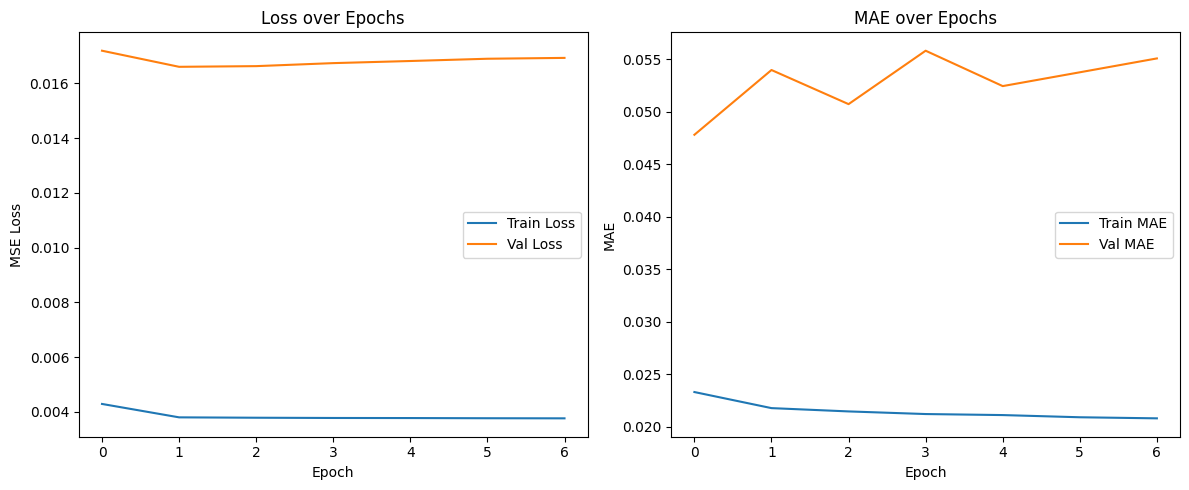

In [59]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.title('MAE over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
from tqdm import tqdm
import numpy as np
with tqdm(total=len(X_test), desc="Prediction Progress") as pbar:
    y_pred = model.predict({'coord_input': X_test, 'user_input': u_test, 'time_input': t_test})
    pbar.update(len(X_test))

In [61]:
def calculate_metrics(preds, targets):
    errors_meters = np.linalg.norm(preds - targets, axis=-1)
    lat_errors = np.abs(preds[:, 0] - targets[:, 0])
    lon_errors = np.abs(preds[:, 1] - targets[:, 1])
    metrics = {
        'ADE ': np.mean(errors_meters),
        'FDE ': errors_meters[-1],
        'Median Error ': np.median(errors_meters),
        '95th Percentile': np.percentile(errors_meters, 95),
        'RMSE ': np.sqrt(np.mean(errors_meters**2)),
        'Max Error': np.max(errors_meters),
        'Lat MAE (deg)': np.mean(lat_errors),
        'Lon MAE (deg)': np.mean(lon_errors)
    }

    for name, value in metrics.items():
        if '%' in name:
            print(f"{name}: {value:.2f}%")
        elif 'deg' in name:
            print(f"{name}: {value:.6f}°")
        else:
            print(f"{name}: {value:.2f}")

    return metrics

In [62]:
metrics = calculate_metrics(y_pred, y_test)

ADE : 0.05
FDE : 0.05
Median Error : 0.01
95th Percentile: 0.19
RMSE : 0.12
Max Error: 0.93
Lat MAE (deg): 0.030704°
Lon MAE (deg): 0.028106°
